In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!pip install fanalysis
from fanalysis.mca import MCA

from sklearn.metrics import confusion_matrix

from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 56 kB 3.2 MB/s 
Mounted at /content/drive


In [2]:
# option d'affichage des résultats
pd.set_option("display.max_row",130)
pd.set_option("display.max_columns",100)

In [3]:
# les noms des variables

colonnes =(["IDENT", "TypeHabi", "GeoFaz_Scl", "GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Anciennete",
            "Logement_prix_m2", "Mediane_RFR", "Sexe", "Prenom_Phase_scl_H", "Prenom_Phase_scl_F",
            "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Age_H", "Age_F", "Affinite_1", "Affinite_2",
            "Prenom_effectif", "Potentiel_prenom", "Onoma-Phase_Scl", "Onoma-Phase_CL", "Top_mon"])

In [4]:
# importation du fichier (changer le chemin d'accès)
''' Faites attention au type de fichier, au délimiteur des valeurs (ça doit être unique et non multiple),
au header et à la lecture des types d'objets (low_memory) '''

data_orig = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/new_my_data_FDFTOT21.txt", delim_whitespace="\t", header = None, names=colonnes, low_memory=False, dtype=str )#, dtype='Int64')


In [5]:
''' copie superficielle (peu profonde) du dataset original pour ne pas modifier les valeurs
d'origine par erreur plus tard 
'''
data = data_orig.copy()
data.shape

(1192180, 23)

In [6]:
# visualisation des premiers lignes
data.head()


,IDENT,TypeHabi,GeoFaz_Scl,GeoFaz_cl,ImmoFaz_Scl,ImmoFaz_cl,Anciennete,Logement_prix_m2,Mediane_RFR,Sexe,Prenom_Phase_scl_H,Prenom_Phase_scl_F,Prenom_Phase_cl_H,Prenom_Phase_cl_F,Age_H,Age_F,Affinite_1,Affinite_2,Prenom_effectif,Potentiel_prenom,Onoma-Phase_Scl,Onoma-Phase_CL,Top_mon
0,000000010010000001,02,81,08,91,09,06,21,21,01,71,41,07,04,12,04,20,02,02,01,51,05,1
1,000000020010000006,01,75,07,43,04,06,06,13,02,71,64,07,06,12,09,04,12,04,13,12,01,1
2,000000030010000011,01,76,07,43,04,06,06,16,03,54,81,05,08,07,12,06,06,04,18,36,03,2
3,000000040010000013,03,75,07,43,04,04,06,13,01,71,36,07,03,12,11,11,19,04,06,21,02,1
4,000000050010000015,02,33,03,44,04,06,07,12,01,71,42,07,04,12,05,14,03,03,01,14,01,2


In [7]:
#nombre de modalités de chaque variables (dans un dataframe)
def nombre_mod(data2):
    #création d'un dataframe vide
    dff= pd.DataFrame(columns=["VARIABLE","NOMBRE_MOD", "NOMBRE_MOD_SANS_NA"])
    for i in range(data2.shape[1]): # sans compter les valeurs manquantes
        taille =len(data2.iloc[:,i].value_counts(dropna=False))
        taille_1 = len(data2.iloc[:,i].value_counts(dropna=True) )
        dff=dff.append({"VARIABLE": colonnes[i],"NOMBRE_MOD":taille, "NOMBRE_MOD_SANS_NA":taille_1 }, ignore_index=True)
    return dff

# sélection des corrélations les plus importantes
def variables_corr(tableau_corr, seuil):
    colonnes = tableau_corr.columns
    val_temp = 0 
    variables_corr_pos=[] ; variables_corr_pos_val=[]
    variables_corr_neg=[] ; variables_corr_neg_val=[]
    for i in range(tableau_corr.shape[0]):  
        for j in range(tableau_corr.shape[0]):
            if i<j: #i!=j:
                if (tableau_corr.iloc[i,j] > seuil):
                    variables_corr_pos.append(colonnes[j])
                    variables_corr_pos_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

                if (tableau_corr.iloc[i,j] <-seuil):
                    variables_corr_neg.append(colonnes[j])
                    variables_corr_neg_val.append(round( tableau_corr.iloc[i,j], 2))
                    val_temp += 1

        if (len(variables_corr_pos) > 0) | (len(variables_corr_neg) >0) :
            print("variable : ", colonnes[i])
            if len(variables_corr_pos) > 0:    
                print("corr pos", variables_corr_pos)
                print("corr pos", variables_corr_pos_val)
                val_temp += 1

            if len(variables_corr_neg) >0:  
                print("corr neg", variables_corr_neg)
                print("corr neg", variables_corr_neg_val)
                val_temp += 1
            print("")
        variables_corr_pos = variables_corr_pos*0
        variables_corr_neg = variables_corr_pos*0

        variables_corr_pos_val = variables_corr_pos_val*0
        variables_corr_neg_val = variables_corr_pos_val*0
    if val_temp == 0:
        print("IL N'Y A PAS DE CORRELATION ENTRE LES VARIABLES PAR RAPPORT AU SEUIL PRIS")
        

def evaluation(model, X_train, y_train, X_test, y_test, scoring, plot):

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print("test set : ")
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred)) 
    print("train set : ")
    print(confusion_matrix(y_train, model.predict(X_train)))  
    print(classification_report(y_train, model.predict(X_train) ))

    if plot == True:
        N, train_score, val_score = learning_curve(model, X_train, y_train, shuffle=True, cv = 4, scoring = scoring, train_sizes = np.linspace(0.1, 1, 6) )

        plt.figure(figsize = (10,6))
        plt.plot(N, train_score.mean(axis=1), label ="train_score")
        plt.plot(N, val_score.mean(axis=1), label ="cross_validation_score")
        plt.legend()
    else :
        print("GRAPHIQUE NON DEMANDE")

# Comme il n'y a pas de valeurs manquantes (à la place il y a un nombre), le seul traitement qu'on fait c'est tranformer
# le type de variable (les variables continues deviennent qualitatives)
def data_processing(df):
    """ 
    for i in range(0,len(df.columns)):    
        df[df.columns[i]].fillna(100.0, inplace=True) #On remplace les données manquantes par 100
    for i in range(0,len(df.columns)):
        print(df[df.columns[i]].value_counts(dropna=False))    
    """
    
   #Transformation de toutes les variables en facteurs         
    for i in range(0,len(df.columns)):
        df[df.columns[i]] = df[df.columns[i]].astype('category')
    return df.to_numpy() #.as_matrix()


def vingtiles(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    #print(df_tous)
    
    # pour la colonne Top_mon :
    # remplissage de la dernière colonne par 2 (VALABLE QUE POUR CE DATA, MODIFIER POUR D'AUTRES)
    data_temp_t = data_orig.copy()
    # remplacement
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(1.0,'1')
    data_temp_t["Top_mon"] =  data_temp_t["Top_mon"].replace(2.0,'2')
    data_all_complet_class = data_temp_t.fillna('2')
    #data_all_complet_class

    # jointure
    ident_class_tous = data_all_complet_class[["IDENT","Top_mon"]]
    tableau_resultats = pd.merge(df_tous,ident_class_tous)
    #tableau_resultats

    # tranches finales
    tab_cross_temp = pd.crosstab(tableau_resultats["TRANCHES"],tableau_resultats["Top_mon"])
    #print(tab_cross_temp); print("-----------------------")

    # création d'une colonne total
    tab_cross_temp["TOTAL"]=tab_cross_temp["1"]+tab_cross_temp["2"]
    
    # affichage
    if affichage ==True:        
        print(tab_cross_temp)

    # création du tableau final en éliminant la colonne 2
    #tab_pour_excel = tab_cross_temp.drop(["2"], axis=1)

    # si on ne veut pas éliminer la colonne 2
    tab_pour_excel =  tab_cross_temp
    
    # enregistrement sous Excel
    if save == True:
        tab_pour_excel.to_excel(path)

def vingtiles_ind_sans_target(model, data_orig, affichage, save, path):
    # position de la dernière variable explicative dans le dataset
    nb_var = data_orig.shape[1]-1

    # predict sur tous les individus (avec et sans classe IFI+)
    tous_probas = model.predict_proba(data_orig.iloc[:,1:nb_var])
    df_tous = pd.DataFrame({'IDENT': data_orig.iloc[:,0] , 'PROBA': tous_probas[:,0] })
    #df_tous
    
    # valeurs ordonnées pour diviser après
    df_tous=df_tous.sort_values(by='PROBA', ascending=True)
    #df_tous
    print(df_tous)
    
    #vérification
    print(df_tous['PROBA'].value_counts())

    # quarantiles
    df_temp =pd.DataFrame( pd.qcut(df_tous['PROBA'],q= 20)  )
    print(df_temp)

    # ajout par index (IMPORTANTE)
    df_tous["TRANCHES"]=pd.DataFrame(df_temp.iloc[:,0].to_numpy(),index= df_temp.index)
    print(df_tous)
    print(df_tous["TRANCHES"].value_counts(ascending = True))

    # GERE L'ORDRE
    patra = np.unique(df_tous.iloc[:,2], return_counts=True)
    df_tranches_sans_target = pd.DataFrame([patra[0],patra[1]]).T
    df_tranches_sans_target.columns=["TRANCHES","COUNTS"]

    # affichage
    if affichage ==True:        
        print(df_tranches_sans_target)
    
    # enregistrement sous Excel
    if save == True:
        df_tranches_sans_target.to_excel(path)
    

# élimination des variables trop corrélées (choix manuel)
def elimination_val_corr(data):
    data = data.drop(columns=[""])
    return data

    

In [8]:
nombre_mod(data)

,VARIABLE,NOMBRE_MOD,NOMBRE_MOD_SANS_NA
0,IDENT,1192180,1192180
1,TypeHabi,4,4
2,GeoFaz_Scl,38,38
3,GeoFaz_cl,8,8
4,ImmoFaz_Scl,31,31
5,ImmoFaz_cl,9,9
6,Anciennete,11,11
7,Logement_prix_m2,21,21
8,Mediane_RFR,21,21
9,Sexe,5,5


In [9]:
data["Top_mon"].value_counts(dropna=False)

NaN    1092884
2        72568
1        26728
Name: Top_mon, dtype: int64

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 23 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   GeoFaz_cl           1192180 non-null  object
 4   ImmoFaz_Scl         1192180 non-null  object
 5   ImmoFaz_cl          1192180 non-null  object
 6   Anciennete          1192180 non-null  object
 7   Logement_prix_m2    1192180 non-null  object
 8   Mediane_RFR         1192180 non-null  object
 9   Sexe                1192180 non-null  object
 10  Prenom_Phase_scl_H  1192180 non-null  object
 11  Prenom_Phase_scl_F  1192180 non-null  object
 12  Prenom_Phase_cl_H   1192180 non-null  object
 13  Prenom_Phase_cl_F   1192180 non-null  object
 14  Age_H               1192180 non-null  object
 15  Age_F               1192180 non-

In [11]:
############################################################### AJOUTER OU EFFACER (data =) #######################################
# on élimine les variables corr
data=data.drop(["GeoFaz_cl", "ImmoFaz_Scl", "ImmoFaz_cl", "Prenom_Phase_cl_H", "Prenom_Phase_cl_F", "Onoma-Phase_Scl", "Onoma-Phase_CL"],axis=1)


In [12]:
num_var_max = data.shape[1] - 1
num_var_max

15

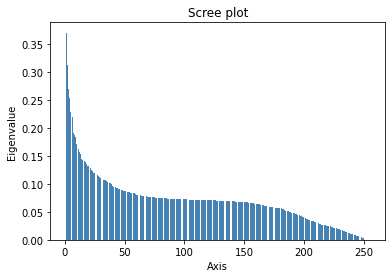

None


In [13]:
#importation de la librairie
from fanalysis.mca import MCA

#instanciation
acm = MCA(var_labels=data.columns[1:num_var_max])

# apprentissage
acm.fit(data.iloc[:127115,1:num_var_max].values)
#valeurs propres - graphique
print(acm.plot_eigenvalues())

In [14]:
# fonction qui va diviser et calculer les coordonnées des individus 
def transform_to_coord(data):
    coord_part = 0
    coord = acm.transform(data.iloc[0:30000,1:num_var_max].values)
    k=30000
    nb_part = round(data.shape[0]/k)
    for i in range(1, nb_part):
        coord_part=acm.transform(data.iloc[i*k:(i+1)*k,1:num_var_max].values)
        coord=np.concatenate((coord, coord_part))

    coord_part = acm.transform(data.iloc[nb_part*k: ,1:num_var_max].values )
    coord=np.concatenate((coord, coord_part))
    return coord

In [15]:
#instanciation
acm = MCA(var_labels = data.columns[1:num_var_max], n_components=55)  # paramètres index manquante (gérer après)
#apprentissage 
"ne pas utiliser fit_tranform car le datset est trop grand "
acm.fit(data.iloc[:127115,1:num_var_max].values)

# tranformation du dataset
coord = transform_to_coord(data)


In [16]:
# dimension
coord.shape

(1192180, 55)

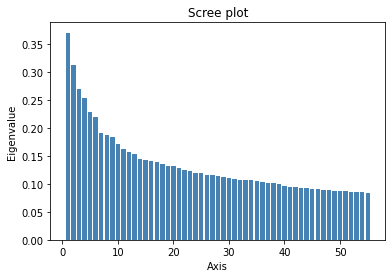

None


In [17]:
#valeurs propres - graphique
print(acm.plot_eigenvalues())


In [18]:
#coordonnées des colonnes
print(acm.col_topandas())

                     col_coord_dim1  col_coord_dim2  col_coord_dim3  \
TypeHabi_01                0.303745       -0.199664       -0.211148   
TypeHabi_02               -0.137910        0.078707        0.088941   
TypeHabi_03                0.122199       -0.010173       -0.038724   
TypeHabi_04                0.078727       -1.065636       -1.803922   
GeoFaz_Scl_11             -0.138645       -0.005575       -0.087617   
...                             ...             ...             ...   
Potentiel_prenom_17       -1.320105        0.090332        0.899473   
Potentiel_prenom_18       -1.182690        0.075362        0.286507   
Potentiel_prenom_19       -1.281801        0.052114       -0.833528   
Potentiel_prenom_20       -1.174645        0.057272       -1.283870   
Potentiel_prenom_21        0.122916       -5.894422        0.417186   

                     col_coord_dim4  col_coord_dim5  col_coord_dim6  \
TypeHabi_01                0.247493       -0.127000        0.242205   
TypeH

In [19]:
#nombre var. actives
p = data.shape[1]-1
print(p)
#calcul des fonctions de projection
fproj = np.zeros(acm.col_coord_.shape)
#pour chaque colonne
for j in range(fproj.shape[1]):
 fproj[:,j] = acm.col_coord_[:,j]/(p*np.sqrt(acm.eig_[0,j]))
#affichage fonction
print(fproj)
#affichage plus avenant des deux premiers facteurs
print(pd.DataFrame(fproj,index=acm.col_labels_))


15
[[ 0.03324437 -0.0237759  -0.02707861 ...  0.00281982  0.01654885
  -0.00949717]
 [-0.01509404  0.00937241  0.01140621 ...  0.000911    0.01365338
  -0.00751397]
 [ 0.01337452 -0.00121141 -0.0049661  ... -0.00860622 -0.10962087
   0.06195295]
 ...
 [-0.14029106  0.00620571 -0.10689556 ... -0.0547016   0.00441292
  -0.06521374]
 [-0.12856302  0.00681995 -0.16464959 ...  0.04475798 -0.01634929
   0.06215476]
 [ 0.01345298 -0.70190616  0.05350198 ... -0.01274137 -0.00915743
   0.00582407]]
                           0         1         2         3         4   \
TypeHabi_01          0.033244 -0.023776 -0.027079  0.032718 -0.017682   
TypeHabi_02         -0.015094  0.009372  0.011406 -0.012967  0.007439   
TypeHabi_03          0.013375 -0.001211 -0.004966  0.002939 -0.002679   
TypeHabi_04          0.008617 -0.126896 -0.231344 -0.011701 -0.258594   
GeoFaz_Scl_11       -0.015174 -0.000664 -0.011236  0.010562  0.012518   
...                       ...       ...       ...       ...       .

In [20]:
# affichafe des 10 premières lignes
print(coord[:2,:])


[[ 8.65858436e-01 -2.35625828e-01 -1.54494638e+00  3.68752335e-01
  -1.58848612e+00  3.21116934e-01  4.82360798e+00  1.02242222e+00
  -5.89303320e-01  1.90506793e-01  3.63270623e-01  4.52554702e-01
   1.31494289e-01 -7.19026194e-01 -5.94359884e-01 -1.14330428e+00
   3.15800167e-01  6.84665970e-01 -2.68761694e-02  4.42044185e-01
   6.16661889e-01  2.31305749e-01  1.51496782e-01 -6.25728926e-02
  -1.92144371e-01 -6.01138135e-01 -2.54451397e-01  3.17509194e-01
   1.78409577e-01  1.28026902e+00 -4.09197845e-01 -1.68039563e+00
  -3.99100539e-01 -3.48748849e-01  5.72044181e-01  1.45399406e+00
  -7.14546540e-01  4.42933533e-01 -9.86906656e-01 -1.30255097e+00
  -4.25773847e-01 -8.83797292e-01  1.39330541e+00 -8.85787576e-01
   1.13669019e+00  3.06047058e-02 -1.78370829e-01  1.01986330e+00
   6.94419816e-01  3.10045053e-02 -1.67183252e-01 -2.03089652e-01
   2.75737687e-01 -2.86690483e-02 -6.52235172e-02]
 [ 5.86313389e-01  5.97338595e-02 -1.25720786e-01  1.36044897e-01
   5.93044480e-01  4.6186

In [21]:
#print(data_sans_nan.shape)
#print(coord_sans_nan.shape)
#print(data_sans_nan.iloc[:,0])
#dfff.isnull().sum(axis=0)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1192180 entries, 0 to 1192179
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype 
---  ------              --------------    ----- 
 0   IDENT               1192180 non-null  object
 1   TypeHabi            1192180 non-null  object
 2   GeoFaz_Scl          1192180 non-null  object
 3   Anciennete          1192180 non-null  object
 4   Logement_prix_m2    1192180 non-null  object
 5   Mediane_RFR         1192180 non-null  object
 6   Sexe                1192180 non-null  object
 7   Prenom_Phase_scl_H  1192180 non-null  object
 8   Prenom_Phase_scl_F  1192180 non-null  object
 9   Age_H               1192180 non-null  object
 10  Age_F               1192180 non-null  object
 11  Affinite_1          1192180 non-null  object
 12  Affinite_2          1192180 non-null  object
 13  Prenom_effectif     1192180 non-null  object
 14  Potentiel_prenom    1192180 non-null  object
 15  Top_mon             99296 non-nu

In [22]:
## ATTENTION
# élimination des individus n'ayant pas de valeur pour la variable Top_mon
data_sans_nan = data[(data.isnull()).sum(axis=1) == 0]
coord_sans_nan = coord[(data.isnull()).sum(axis=1) == 0] # coordonnées

#conversion du type de variable
for i in range(1,data_sans_nan.shape[1]):
    data_sans_nan.iloc[:,i]=data_sans_nan.iloc[:,i].astype(int) # essayer avec int64

# création
def creation_df_temp(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1] ): #avant 10
        dfff[str(i)]=coord_sans_nan[:,i]
    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1].astype(int)
    return dfff
# stockage
data_coord_nan = creation_df_temp(data_sans_nan, coord_sans_nan)
data_coord_nan.info()
#data_coord_nan = dfff 

# maintien des individus  n'ayant pas de valeur pour la variable Top_mon

data_avec_nan = data
coord_avec_nan = coord # coordonnées
def creation_df_temp_2(data_sans_nan, coord_sans_nan):
    dfff = pd.DataFrame()
    dfff["IDENT"] = data_sans_nan.iloc[:,0]
    for i in range(coord_sans_nan.shape[1]): # avant 10
        dfff[str(i)]=coord_sans_nan[:,i]

    dfff["Top_mon"] = data_sans_nan.iloc[:,data_sans_nan.shape[1]-1] #.astype(int)

    dfff["Top_mon"] = dfff["Top_mon"].replace(1.0, '1')
    dfff["Top_mon"] = dfff["Top_mon"].replace(2.0,'2')
    #for j in range(data_sans_nan.shape[1]):
    #    if dfff.iloc[j,10+1] == 2.0:
    #        dfff.iloc[j,10+1] = 2
    #    if dfff.iloc[j, 10+1] ==1.0:
    #        dfff.iloc[j,10+1] =1

    return dfff
data_coord_avec_nan = creation_df_temp_2(data_avec_nan, coord_avec_nan)
data_coord_avec_nan.info()



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 99296 entries, 0 to 99295
Data columns (total 57 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   IDENT    99296 non-null  object 
 1   0        99296 non-null  float64
 2   1        99296 non-null  float64
 3   2        99296 non-null  float64
 4   3        99296 non-null  float64
 5   4        99296 non-null  float64
 6   5        99296 non-null  float64
 7   6        99296 non-null  float64
 8   7        99296 non-null  float64
 9   8        99296 non-null  float64
 10  9        99296 non-null  float64
 11  10       99296 non-null  float64
 12  11       99296 non-null  float64
 13  12       99296 non-null  float64
 14  13       99296 non-null  float64
 15  14       99296 non-null  float64
 16  15       99296 non-null  float64
 17  16       99296 non-null  float64
 18  17       99296 non-null  float64
 19  18       99296 non-null  float64
 20  19       99296 non-null  float64
 21  20       992

In [23]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV

import imblearn
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [24]:
#data_coord_nan.shape
#train_X_s.shape

In [25]:
#data_non_corr = elimination_val_corr(data)
#nb_var = data_non_corr.shape[1] - 1
nb_var = data_coord_nan.shape[1] - 1

train_set, test_set = train_test_split(data_coord_nan, test_size = 0.2, random_state=0) # , stratify =data_coord_nan["IFI+"] )

train_X_s = (train_set.iloc[:,1:nb_var]).to_numpy()
train_Y_s = np.asanyarray(train_set.iloc[:,nb_var])

test_X_s = (test_set.iloc[:,1:nb_var]).to_numpy()
test_Y_s = np.asanyarray(test_set.iloc[:,nb_var])

# comme les résulats sont en overfitting :
# Résultat du traitement sur le train set (under-sampling et over-sampling)
#abc_test = pd.read_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/sans_val_corr_spad_under_over_sampling.txt", delim_whitespace="\t", header = None, low_memory=False, dtype="Int64" ) #, dtype='Int64')
#abc_np = abc_test.to_numpy(dtype="Int64")

#X_resampled = abc_np[:,:-1]
#y_resampled = abc_np[:, abc_np.shape[1] -1 ]


In [26]:

# dimension du train set
print("Sans aucun traitement sur le train set : " , np.unique(train_Y_s, return_counts=True))

# diminution des données
t2 = TomekLinks()
X_resampled, y_resampled = t2.fit_resample(train_X_s[:,:nb_var] , train_Y_s )
print("Après under-sampling : ", np.unique(y_resampled, return_counts=True ))

# augmentation des données
tl = SMOTE()
X_resampled, y_resampled = tl.fit_resample(X_resampled, y_resampled )
print("Après over-smapling : " , np.unique(y_resampled, return_counts=True ))

'''
# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps 
pd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),
                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",
                                            sep=" ", index =False , header = False )
'''

Sans aucun traitement sur le train set :  (array([1, 2]), array([21397, 58039]))


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Après under-sampling :  (array([1, 2]), array([21397, 51053]))
Après over-smapling :  (array([1, 2]), array([51053, 51053]))


'\n# enregistrement du nouveau train set car le traitement du under-sampling prendre du temps \npd.DataFrame(np.concatenate((X_resampled, y_resampled.reshape((y_resampled.shape[0],1)) ),\n                            axis=1)).to_csv("/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/val_all_spad_under_over_sampling.txt",\n                                            sep=" ", index =False , header = False )\n'

In [27]:
model_LinearDiscriminantAnalysis = LinearDiscriminantAnalysis()
param = {"solver" : ["svd","lsqr", "eigen"], "tol" : [0.00001,0.0001,0.001,0.01]}

grid_LinearDiscriminantAnalysis = GridSearchCV(model_LinearDiscriminantAnalysis, param_grid= param, cv = 4, scoring = "f1")
resultat_grid_LinearDiscriminantAnalysis = grid_LinearDiscriminantAnalysis.fit(X_resampled, y_resampled)
resultat_grid_LinearDiscriminantAnalysis.best_params_ 

{'solver': 'svd', 'tol': 1e-05}

test set : 
[[3194 2137]
 [5922 8607]]
              precision    recall  f1-score   support

           1       0.35      0.60      0.44      5331
           2       0.80      0.59      0.68     14529

    accuracy                           0.59     19860
   macro avg       0.58      0.60      0.56     19860
weighted avg       0.68      0.59      0.62     19860

train set : 
[[30257 20796]
 [19820 31233]]
              precision    recall  f1-score   support

           1       0.60      0.59      0.60     51053
           2       0.60      0.61      0.61     51053

    accuracy                           0.60    102106
   macro avg       0.60      0.60      0.60    102106
weighted avg       0.60      0.60      0.60    102106



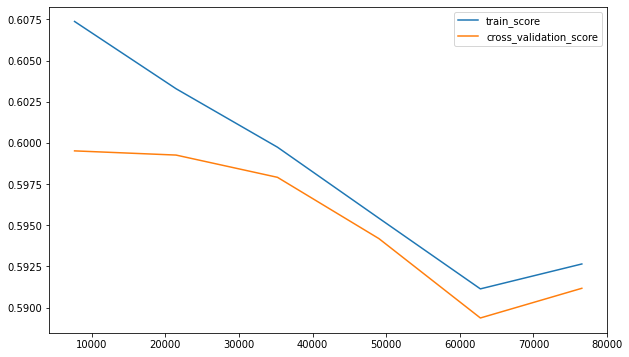

In [28]:
final_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(final_model_ADL, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "recall", plot=True)

In [29]:
#classe pour l'analyse discriminante

#instanciation
adl = LinearDiscriminantAnalysis()
#apprentissage
adl.fit(coord_sans_nan,data_sans_nan["Top_mon"])

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [30]:
#reconstitution de la fonction sur indicatrices (multiplication)
fpValues = np.dot(fproj,np.transpose(adl.coef_))
#print(fpValues)
#affichage plus joli
pd.DataFrame(fpValues,index=acm.col_labels_)

,0
TypeHabi_01,-0.094146
TypeHabi_02,0.040044
TypeHabi_03,-0.021030
TypeHabi_04,-0.459074
GeoFaz_Scl_11,-0.048054
...,...
Potentiel_prenom_17,-0.029626
Potentiel_prenom_18,-0.081947
Potentiel_prenom_19,-0.078719
Potentiel_prenom_20,-0.139699


In [31]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model = final_model_ADL, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADL_55.xlsx")

                    IDENT     PROBA
11693  000116940010258609  0.112241
73678  000736790010408023  0.112652
85390  000853910010519316  0.112653
81950  000819510010418095  0.133478
21974  000219750010338341  0.134662
...                   ...       ...
88310  000883110010524335  0.872031
75590  000755910010410331  0.872031
12520  000125210010259455  0.872031
2071   000020720010027021  0.872031
76474  000764750010411847  0.876580

[99296 rows x 2 columns]
0.834581    49
0.806596    28
0.641273    24
0.827811    19
0.770022    19
            ..
0.546830     1
0.309273     1
0.478042     1
0.237724     1
0.433071     1
Name: PROBA, Length: 96552, dtype: int64
                PROBA
11693  (0.111, 0.291]
73678  (0.111, 0.291]
85390  (0.111, 0.291]
81950  (0.111, 0.291]
21974  (0.111, 0.291]
...               ...
88310  (0.698, 0.877]
75590  (0.698, 0.877]
12520  (0.698, 0.877]
2071   (0.698, 0.877]
76474  (0.698, 0.877]

[99296 rows x 1 columns]
Top_mon            1     2  TOTAL
TRANCHES    

In [32]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = final_model_ADL, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADL_55.xlsx")

                      IDENT     PROBA
749506   006502110280062284  0.082464
714594   006152990280027372  0.083086
502150   004028550190018414  0.083967
114787   000154920020005328  0.092190
123955   000246600020014496  0.093185
...                     ...       ...
440094   003407990150007388  0.872031
360851   002615560130008835  0.877313
895764   007964690340001932  0.877320
369541   002702460130017525  0.886281
1100225  010009300370017393  0.890951

[1092884 rows x 2 columns]
0.746707    303
0.827811    229
0.813524    223
0.806596    222
0.824543    214
           ... 
0.381486      1
0.440508      1
0.589199      1
0.577889      1
0.615912      1
Name: PROBA, Length: 838236, dtype: int64
                  PROBA
749506   (0.0815, 0.29]
714594   (0.0815, 0.29]
502150   (0.0815, 0.29]
114787   (0.0815, 0.29]
123955   (0.0815, 0.29]
...                 ...
440094   (0.709, 0.891]
360851   (0.709, 0.891]
895764   (0.709, 0.891]
369541   (0.709, 0.891]
1100225  (0.709, 0.891]

[1092884 

In [33]:
model_ADQ = QuadraticDiscriminantAnalysis()
evaluation(model_ADQ, X_resampled, y_resampled, test_X_s, test_Y_s, scoring = "f1", plot=False)


test set : 
[[2857 2474]
 [5180 9349]]
              precision    recall  f1-score   support

           1       0.36      0.54      0.43      5331
           2       0.79      0.64      0.71     14529

    accuracy                           0.61     19860
   macro avg       0.57      0.59      0.57     19860
weighted avg       0.67      0.61      0.63     19860

train set : 
[[27216 23837]
 [17465 33588]]
              precision    recall  f1-score   support

           1       0.61      0.53      0.57     51053
           2       0.58      0.66      0.62     51053

    accuracy                           0.60    102106
   macro avg       0.60      0.60      0.59    102106
weighted avg       0.60      0.60      0.59    102106

GRAPHIQUE NON DEMANDE


In [34]:
#data_coord_nan
# TRAIN SET TEST SET
vingtiles(model =model_ADQ, data_orig = data_coord_nan, affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ACM_ADQ_55.xlsx")

                    IDENT          PROBA
96630  000966310010536346  9.579408e-136
48464  000484650010373833  1.351022e-114
22351  000223520010338758  4.751045e-114
19914  000199150010330026  3.831633e-113
16933  000169340010264546  4.835280e-113
...                   ...            ...
17028  000170290010264641   1.000000e+00
17019  000170200010264632   1.000000e+00
54674  000546750010381119   1.000000e+00
87639  000876400010522217   1.000000e+00
79510  000795110010415499   1.000000e+00

[99296 rows x 2 columns]
1.000000    297
1.000000     49
1.000000     28
0.997447     24
1.000000     19
           ... 
0.131399      1
0.783807      1
0.000092      1
0.005389      1
0.518411      1
Name: PROBA, Length: 96269, dtype: int64
                      PROBA
96630  (-0.0001, 3.296e-05]
48464  (-0.0001, 3.296e-05]
22351  (-0.0001, 3.296e-05]
19914  (-0.0001, 3.296e-05]
16933  (-0.0001, 3.296e-05]
...                     ...
17028         (0.9999, 1.0]
17019         (0.9999, 1.0]
54674        

In [35]:
# INDIVIDUS SANS TARGET
vingtiles_ind_sans_target(model = model_ADQ, data_orig= data_coord_avec_nan[(data_coord_avec_nan.isnull()).sum(axis=1) != 0], affichage=True,
            save=True, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/ind_sans_target_ACM_ADQ_55.xlsx")

                      IDENT          PROBA
1089744  009904490370006912  3.329303e-117
356317   002570220130004301  3.707245e-116
415332   003160370130063316  4.116768e-116
993114   008938190360070282  5.169154e-115
603251   005039560220045489  6.909475e-115
...                     ...            ...
1098594  009992990370015762   1.000000e+00
1109956  010106610370027124   1.000000e+00
397755   002984600130045739   1.000000e+00
602239   005029440220044477   1.000000e+00
245528   001462330070001220   1.000000e+00

[1092884 rows x 2 columns]
1.000000e+00    4044
9.999950e-01     303
1.000000e+00     229
9.999994e-01     223
1.000000e+00     222
                ... 
1.111388e-02       1
2.336203e-02       1
2.135922e-01       1
9.192105e-08       1
9.454883e-01       1
Name: PROBA, Length: 835765, dtype: int64
                       PROBA
1089744  (-0.0001, 6.16e-05]
356317   (-0.0001, 6.16e-05]
415332   (-0.0001, 6.16e-05]
993114   (-0.0001, 6.16e-05]
603251   (-0.0001, 6.16e-05]
...      

In [ ]:
###############################################################################
###############################################################################

In [37]:
# SANS UNDER-SAMPLING ET OVER-SAMPLING

print("ADL test sans under-sampling et over_sampling")
test_model_ADL = LinearDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADL, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

print("ADQ test sans under-sampling et over_sampling")
test_model_ADQ = QuadraticDiscriminantAnalysis()  # la valeur par defaut de la tolérence donne le même résultat que tol=1e-5
evaluation(test_model_ADQ, train_X_s, train_Y_s, test_X_s, test_Y_s, scoring = "f1", plot=False)

vingtiles(model =test_model_ADQ, data_orig = data_coord_nan, affichage=True,
          save=False, path = "/content/drive/MyDrive/spad_score_method_1/spad_projection_FDFTOT21/Fichier_excel_vingtiles/train_test_ADL.xlsx")


ADL test sans under-sampling et over_sampling
test set : 
[[  410  4921]
 [  366 14163]]
              precision    recall  f1-score   support

           1       0.53      0.08      0.13      5331
           2       0.74      0.97      0.84     14529

    accuracy                           0.73     19860
   macro avg       0.64      0.53      0.49     19860
weighted avg       0.68      0.73      0.65     19860

train set : 
[[ 1568 19829]
 [ 1286 56753]]
              precision    recall  f1-score   support

           1       0.55      0.07      0.13     21397
           2       0.74      0.98      0.84     58039

    accuracy                           0.73     79436
   macro avg       0.65      0.53      0.49     79436
weighted avg       0.69      0.73      0.65     79436

GRAPHIQUE NON DEMANDE
ADQ test sans under-sampling et over_sampling
test set : 
[[ 1958  3373]
 [ 3212 11317]]
              precision    recall  f1-score   support

           1       0.38      0.37      0.37    

In [ ]:
#################################################################################
#################################################################################

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from scipy.stats import shapiro

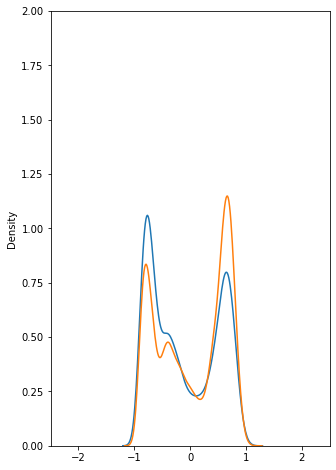

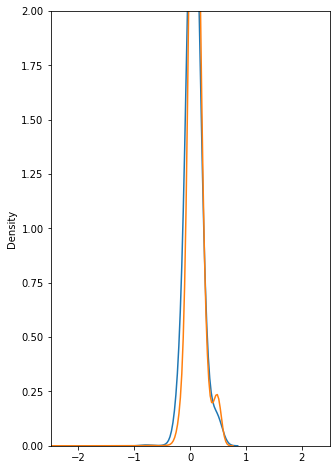

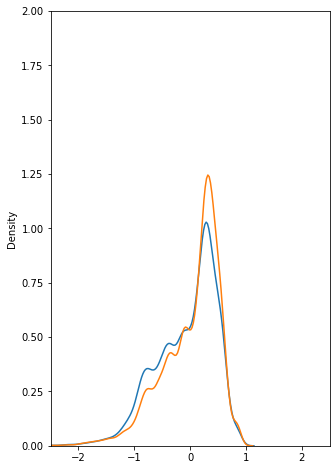

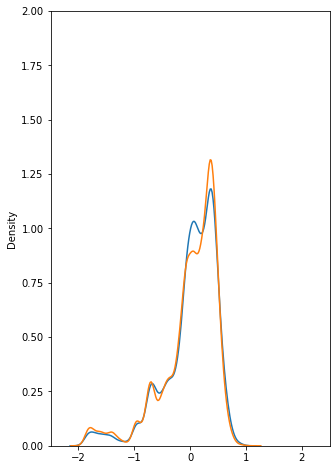

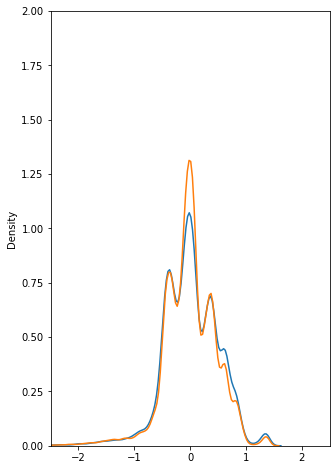

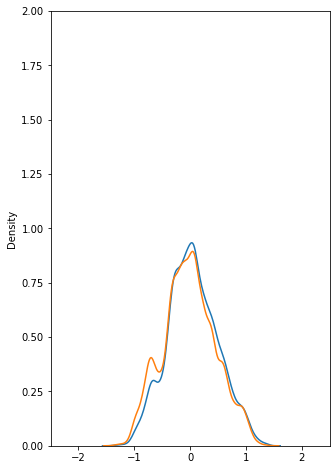

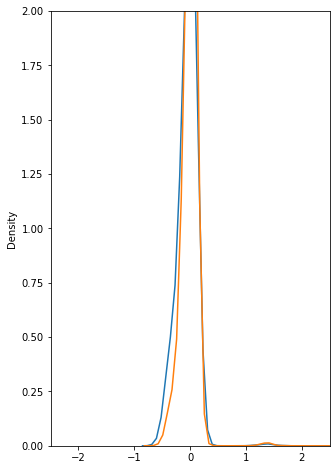

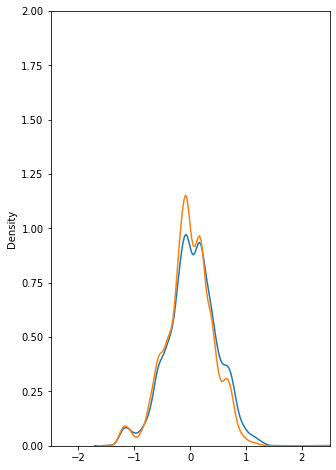

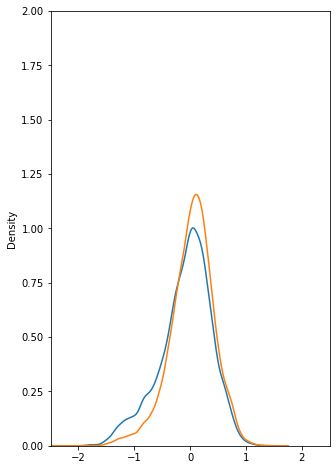

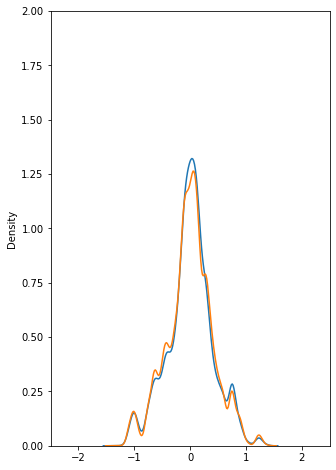

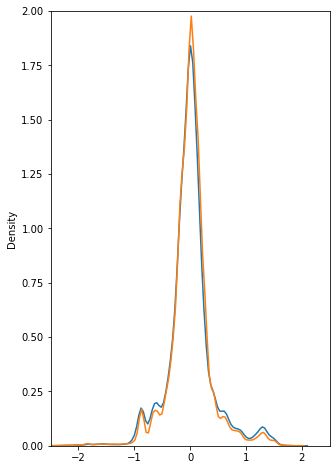

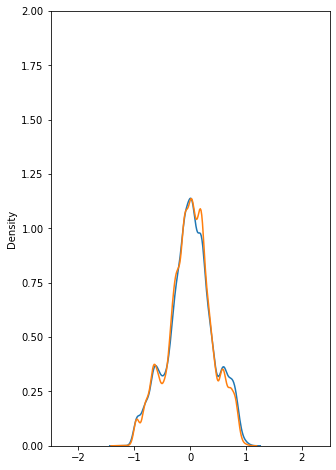

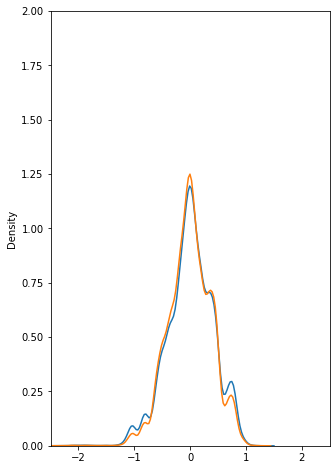

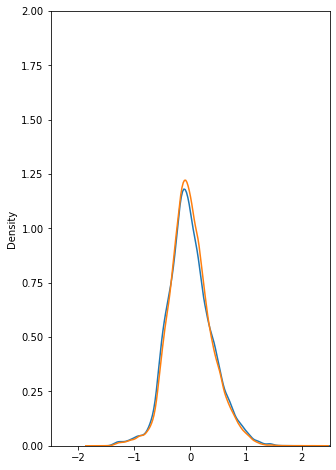

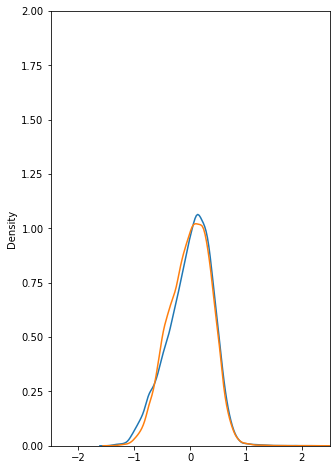

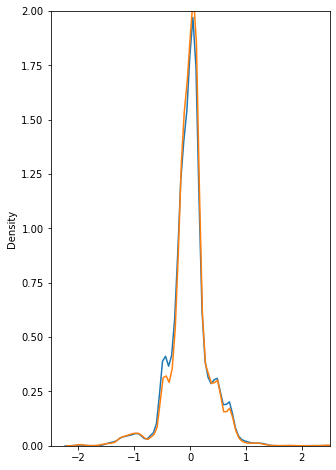

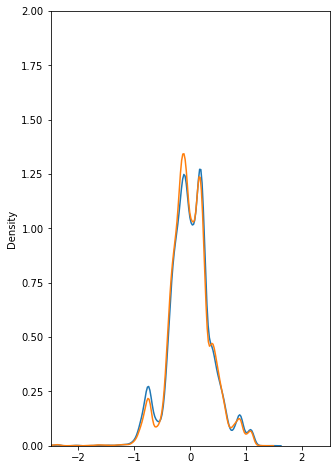

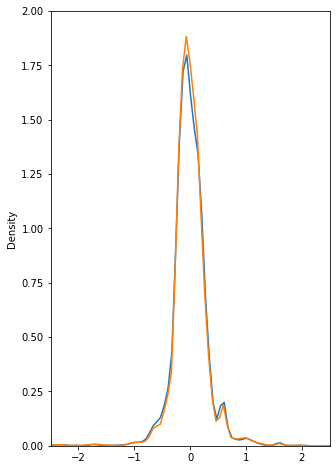

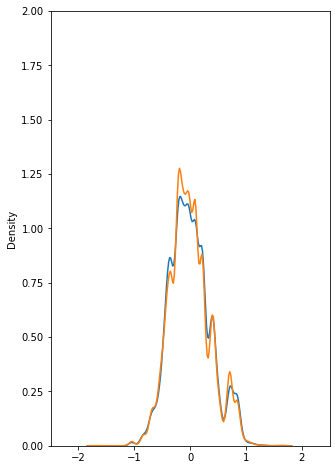

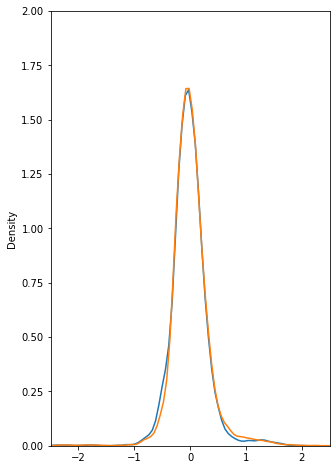

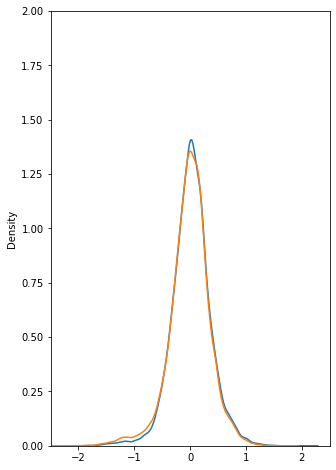

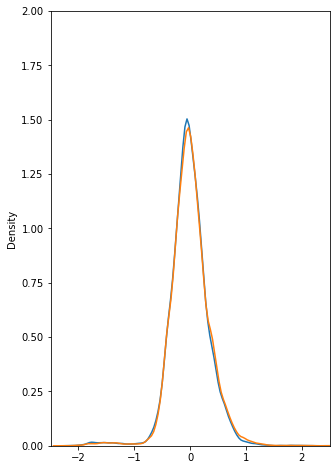

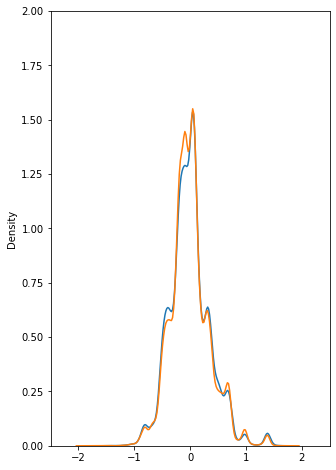

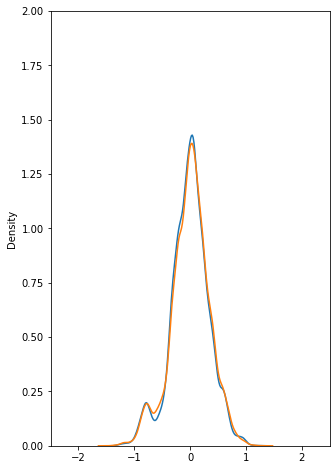

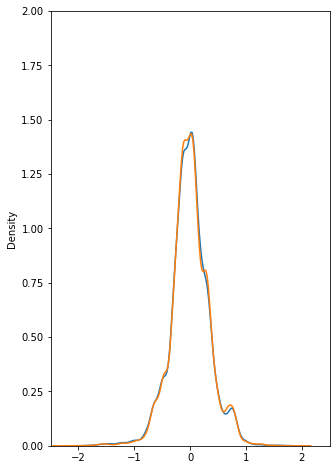

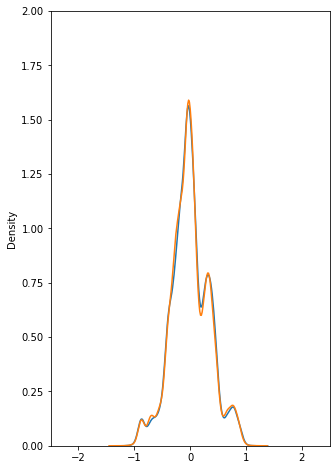

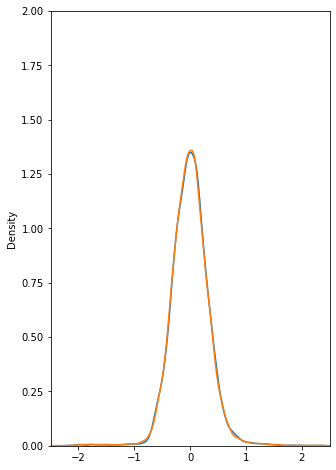

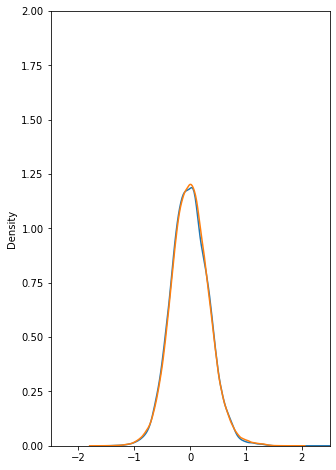

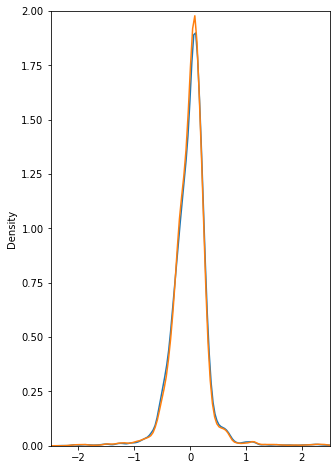

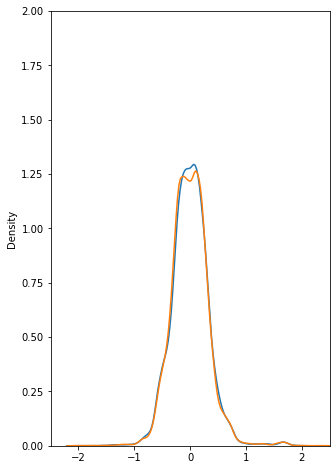

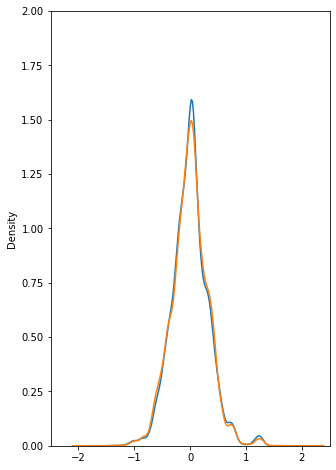

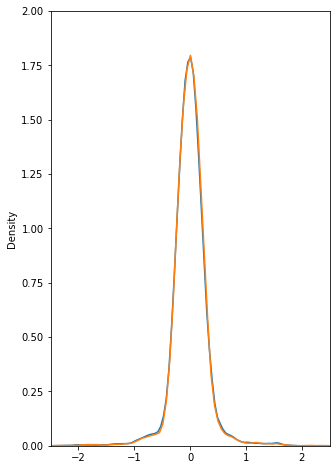

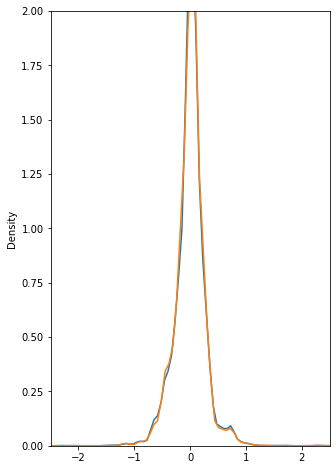

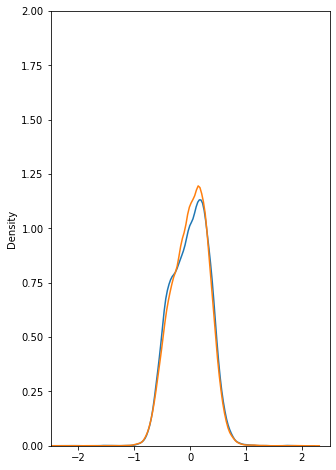

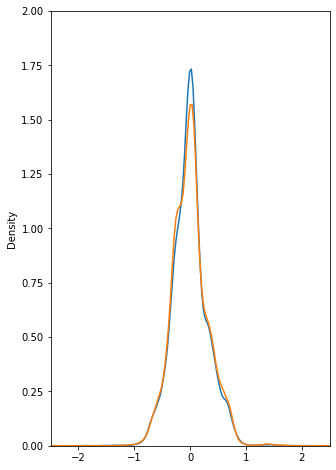

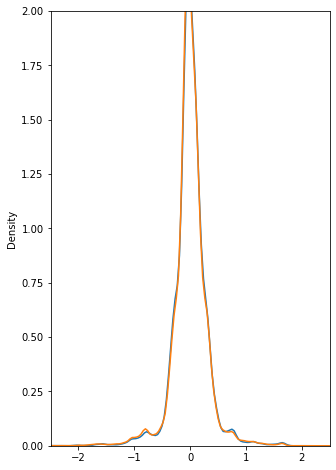

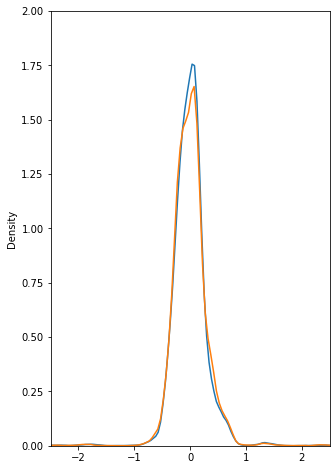

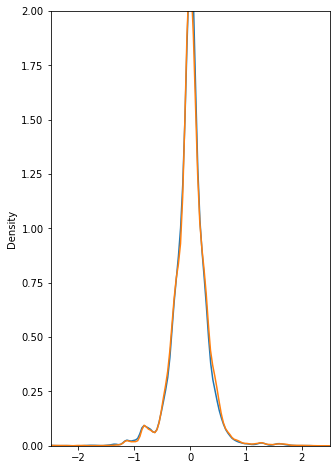

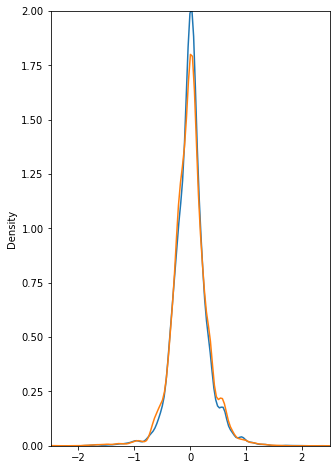

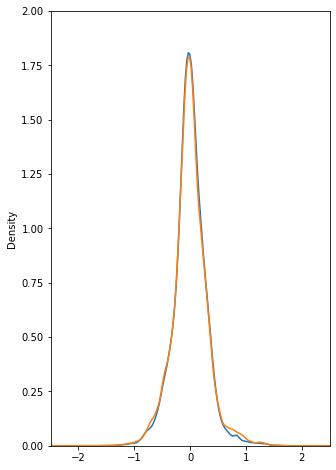

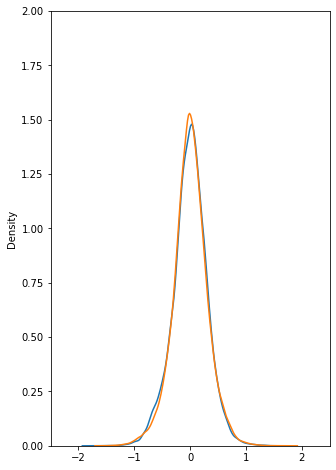

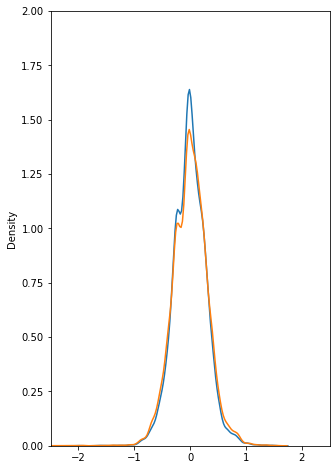

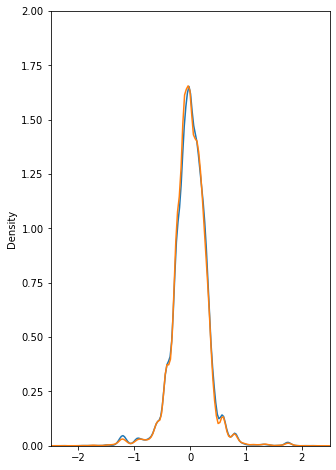

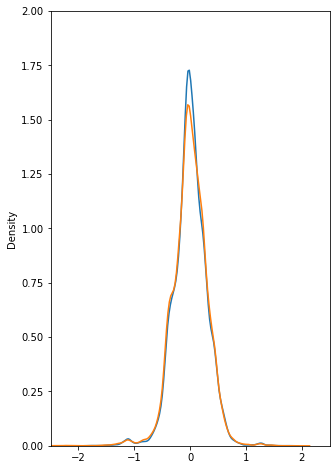

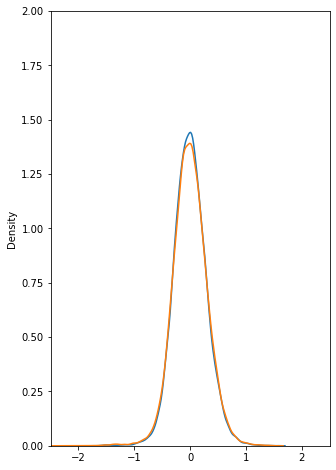

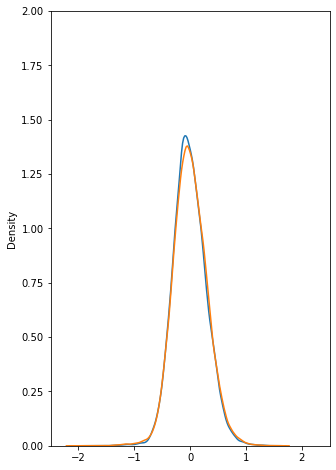

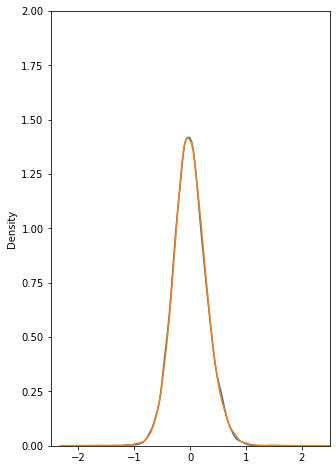

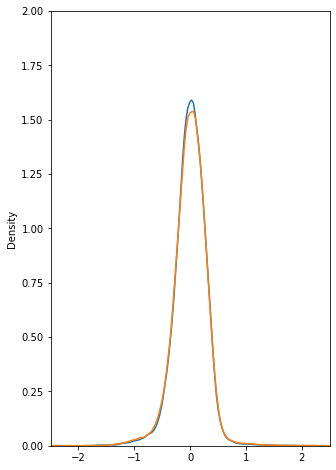

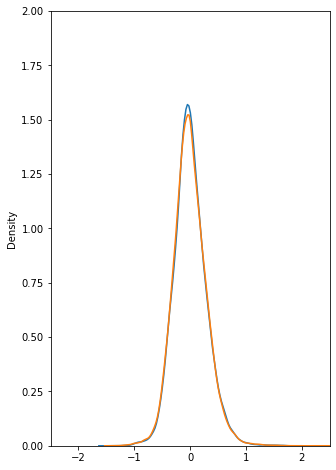

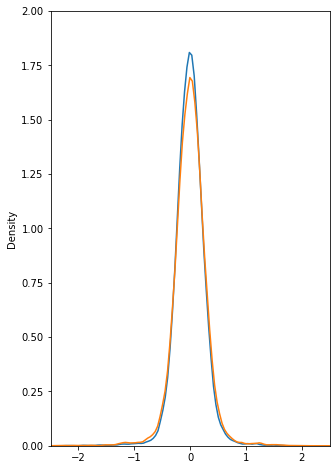

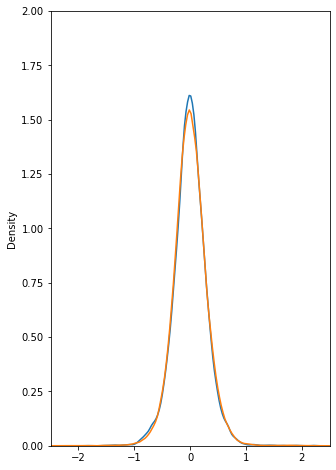

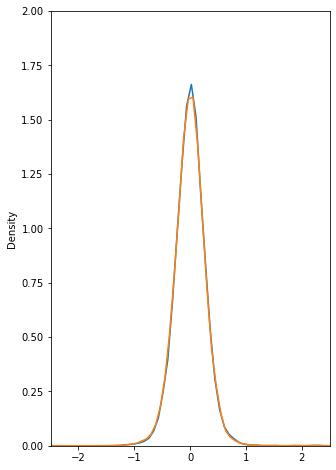

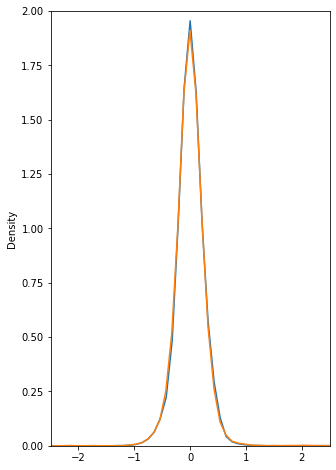

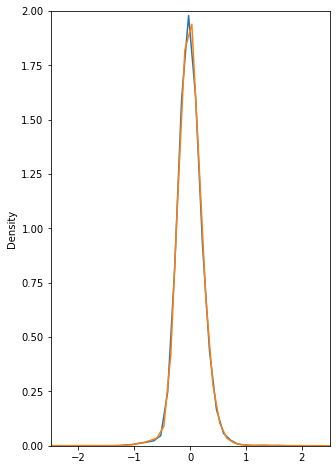

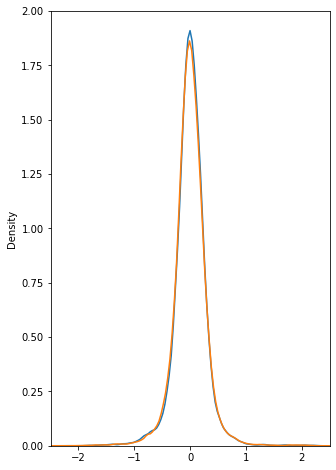

In [ ]:

for i in range(0,55):
    plt.figure(figsize=(5,8))
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,i],hist=False) 
    sns.distplot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,i],hist=False) 
    plt.xlim((-2.5,2.5))
    plt.ylim((0,2))


In [ ]:
for j in range(55):
    print( shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,j]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j]) )

(0.8902812600135803, 0.0) (0.8890335559844971, 0.0)
(0.3441219925880432, 0.0) (0.3285287618637085, 0.0)
(0.9475054740905762, 0.0) (0.9207664728164673, 0.0)
(0.8832073211669922, 0.0) (0.8703444600105286, 0.0)
(0.9622422456741333, 0.0) (0.9486756324768066, 0.0)
(0.9966996312141418, 1.627029876867225e-23) (0.9951626062393188, 1.083175686953797e-40)
(0.17553561925888062, 0.0) (0.19791096448898315, 0.0)
(0.9878847599029541, 9.125255599683209e-42) (0.9884916543960571, 0.0)
(0.9643225073814392, 0.0) (0.9728494882583618, 0.0)
(0.9867238402366638, 2.942726775082116e-43) (0.9906708598136902, 0.0)
(0.8827170133590698, 0.0) (0.8646377325057983, 0.0)
(0.9911522269248962, 7.472830549670618e-37) (0.9918988943099976, 0.0)
(0.9862679839134216, 8.127531093083939e-44) (0.9875761866569519, 0.0)
(0.9876701831817627, 4.7461978986681554e-42) (0.9892139434814453, 0.0)
(0.9845070838928223, 1.401298464324817e-45) (0.990972638130188, 0.0)
(0.8489938974380493, 0.0) (0.8305317163467407, 0.0)
(0.9773634672164917, 0

In [ ]:
shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==1,:]), shapiro(coord_sans_nan[data_sans_nan.iloc[:,15]==2,:])

((0.9002602100372314, 0.0), (0.9269148111343384, 0.0))

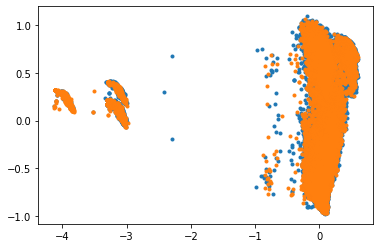

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,0],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,0],".")

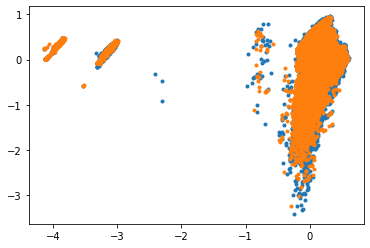

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,1], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

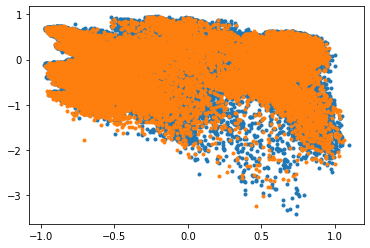

In [ ]:
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==2,0], coord_sans_nan[data_sans_nan.iloc[:,15]==2,2],".")
plt.plot(coord_sans_nan[data_sans_nan.iloc[:,15]==1,0], coord_sans_nan[data_sans_nan.iloc[:,15]==1,2],".")

In [ ]:
for j in range(55):#23456
    hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==2,j])
    
    q_low = hhh.quantile(0.05)
    q_hi  = hhh.quantile(0.95)
    df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]

    print(shapiro(df_filtered.dropna()))


(0.882647693157196, 0.0)
(0.9924656748771667, 0.0)
(0.9249191880226135, 0.0)
(0.9213275909423828, 0.0)
(0.9789981245994568, 0.0)
(0.9862045049667358, 0.0)
(0.9680637121200562, 0.0)
(0.9889523386955261, 0.0)
(0.9878354072570801, 0.0)
(0.9902550578117371, 0.0)
(0.9931141138076782, 4.203895392974451e-45)
(0.9890395998954773, 0.0)
(0.9846316576004028, 0.0)
(0.9828740954399109, 0.0)
(0.9736987352371216, 0.0)
(0.9847355484962463, 0.0)
(0.9891963601112366, 0.0)
(0.9906045198440552, 0.0)
(0.9785979390144348, 0.0)
(0.9863490462303162, 0.0)
(0.9916952848434448, 0.0)
(0.9851601123809814, 0.0)
(0.9846998453140259, 0.0)
(0.9925500750541687, 0.0)
(0.9932748675346375, 9.80908925027372e-45)
(0.9833292961120605, 0.0)
(0.9866969585418701, 0.0)
(0.9851335883140564, 0.0)
(0.978935718536377, 0.0)
(0.9859058260917664, 0.0)
(0.9873499870300293, 0.0)
(0.9876349568367004, 0.0)
(0.9844759702682495, 0.0)
(0.9722975492477417, 0.0)
(0.9857660531997681, 0.0)
(0.9927337169647217, 0.0)
(0.9861541986465454, 0.0)
(0.99

(26728, 1)
(26728, 1)


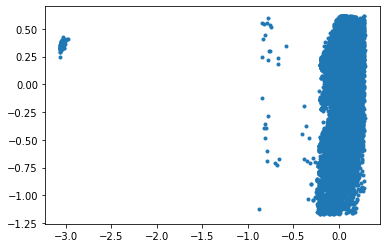

In [ ]:
hhh = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,1])
q_low = hhh.quantile(0.03)
q_hi  = hhh.quantile(0.95)
df_filtered = hhh[(hhh < q_hi) & (hhh > q_low)]
print(df_filtered.shape)

hhh_2 = pd.DataFrame(coord_sans_nan[data_sans_nan.iloc[:,15]==1,2])
q_low_2 = hhh_2.quantile(0.03)
q_hi_2  = hhh_2.quantile(0.95)
df_filtered_2 = hhh_2[(hhh_2 < q_hi_2) & (hhh_2 > q_low_2)]
print(df_filtered_2.shape)

plt.plot(df_filtered.iloc[:,0], df_filtered_2.iloc[:,0], '.')

In [ ]:

'''
from sklearn.preprocessing import KBinsDiscretizer
# discrétisation des variables continues (les valeurs manquantes doivent être gérées en amont)
 c'est qui est bien avec KBinsDiscretizer est qu'il s'adapte aux éventuelles partitions au
sein d'une variable. En d'autres termes, si la méthode n'arrive pas à partitionner les individus
en k partitions, alors elle esssayera de les partitionner en k-1 partitions, et ainsi de suite, 
jusqu'à atteindre 1 partition (il faut faire attention avec les variables ayant uniquement 
une modalité). Lorsque la méthode rencontre ce cas, elle affichera "UserWaring" pour informer 
l'utilisateur de celui-ci ainsi que les variables concernées. Ceci sera utile plus tard.


method_discre = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile') 
method_discre.fit(data.iloc[:,1:23])
resultat_discre = method_discre.transform(data.iloc[:,1:23])
resultat_discre

# construction du data frame après discrétisation
data2_index = data.iloc[:,0]
df_resultat_discre = pd.DataFrame(resultat_discre,columns=colonnes[1:23], dtype=int )
data_final = pd.concat([data2_index, df_resultat_discre,data["IFI+"]], axis=1 ) #data2_index
data_final

#nombre_mod(data_final)
#nombre_mod(data)

# description des modalités d'une variable
for k in range(1,data_final.shape[1]):
    print(data_final.iloc[:,k].value_counts(dropna=True)); print("="*50)

# description des modalités d'une variable
for k in range(1,data.shape[1]):
    print(data.iloc[:,k].value_counts(dropna=True)); print("="*50)

'''


In [ ]:
###########################################################################################################
#  PIPELINE

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline

In [ ]:
disqual =  Pipeline([("acm", MCA(var_labels = data.columns[1:num_var_max], )),("adl", LinearDiscriminantAnalysis())])

In [ ]:
disqual.fit(data.iloc[:127115, 1:-1].values, data.iloc[:127115, num_var_max] )



In [ ]:
#accès à l'ACM, nombre de composants
print(disqual.named_steps["acm"].n_components_)


In [ ]:
#afficher les valeurs propres
disqual.named_steps["acm"].plot_eigenvalues()


In [ ]:
#coefs. de la fonction score
print(disqual.named_steps["adl"].coef_)


In [ ]:
#prediction
pVote = disqual.predict(vote_test.iloc[:,:-1].values)
print(numpy.unique(pVote,return_counts=True))


In [ ]:
#nombres de facteurs à tester
parametres = [{"acm__n_components":[1,2,5,10,15,20,25,30,32]}]

In [ ]:
1771/4964

0.35676873489121674